# Overview

This notebook served as the **playground** for developing the simulation loops and versions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import time

from pathlib import Path

# Develop Simulation setup
## DONT FORGET TO MULTIPLY between euclidean distances

In [2]:
"""
Function to convert 2D dataframe of numpy arrays to the following:
- large 1D array of values
- 2D array of bin starts within the 1D array
- 2D array of bin lengths within the 1D array
- If a cell entry is an empty array, then it will be replaced by one entry of np.inf (should only apply to inbetween variables)

"""
def convert_array_df(array_df):

    #print("columns:", array_df.columns)
    #print("rows:", array_df.index)

    missing_cols = check_series_is_full(array_df.columns)
    missing_rows = check_series_is_full(array_df.index)

    if len(missing_rows) > 0 or len(missing_cols) > 0:
        print("Filling in missing columns and rows with empty arrays")
        print("missing cols:", missing_cols)
        print("missing rows:", missing_rows)

        array_df = fill_df_missing_cols_rows(array_df)

    num_rows, num_cols = array_df.shape

    starts  = np.zeros((num_rows, num_cols), dtype=np.int64)
    lengths = np.zeros((num_rows, num_cols), dtype=np.int64)

    flat = []
    
    curr = 0
    for i in range(num_rows):
        for j in range(num_cols):

            arr = array_df.iat[i, j]

            # if the array is empty, just replace it with np.inf array
            if arr is None or len(arr) == 0:
                arr = np.array([np.inf])

            arr = np.asarray(arr)

            starts[i, j] = curr
            lengths[i, j]   = arr.size

            flat.append(arr)
            curr += arr.size

    flat = np.concatenate(flat)

    return {'values' : flat, 'starts' : starts, 'lengths' : lengths, 
            'min_row' : array_df.index.min(), 'min_col' : array_df.columns.min(),
            'cols' : array_df.columns, 'rows' : array_df.index}


def check_series_is_full(series):
    missing = set(range(series.min(), series.max() + 1)) - set(series)
    
    return missing

def fill_df_missing_cols_rows(df):
    # create indexes for full range
    full_index  = range(df.index.min(),   df.index.max()   + 1)
    full_columns = range(df.columns.min(), df.columns.max() + 1)

    # re-index to this complete index
    df = df.reindex(index=full_index, columns=full_columns)
    
    # this created NaNs, which we can fill with empty arrays
    df = df.map(lambda v: np.array([])    if     (v is None or (isinstance(v, float)     and np.isnan(v)))         else v)

    return df

In [3]:
"""
Function to load information for sampling.

This includes the following variables:

- inbetween_miles_arrays:   (PU, DO)      #NEEDS MULTIPLICATION
- inbetween_minutes_arrays: (PU, DO)

- shift_durations: (hour,day)
- shift_start_locations: (hour, day)

- driver_count_arrays: (hour, day)
- driver_count_deltas: (hour, day)


To speed up sampling, each variable distribution will be given by:
- large 1D array of values
- 2D array of bin starts within the 1D array
- 2D array of bin lengths within the 1D array
- If a cell entry is an empty array, then it will be replaced by one entry of np.inf (should only apply to inbetween variables)

NOTE: Everything is converted into seconds or miles

"""
def load_sampling_stuff():
    import gc

    print("Loading sampling info:")
    
    print("Shift durations...")
    shift_durations = pd.read_pickle("data/sim_info/shift_arrays.pkl")
    shift_durations_info = convert_array_df(shift_durations)
    del shift_durations
    gc.collect()

    print("Shift start locations...")
    shift_start_locations = pd.read_pickle("data/sim_info/shift_start_location_arrays.pkl")
    shift_start_locations_info = convert_array_df(shift_start_locations)
    del shift_start_locations
    gc.collect()
    

    print("driver counts...")
    driver_counts = pd.read_pickle("data/sim_info/driver_count_arrays.pkl")
    driver_counts_info = convert_array_df(driver_counts)
    del driver_counts
    gc.collect()

    print("driver count deltas...")
    driver_count_deltas = pd.read_pickle("data/sim_info/driver_delta_arrays.pkl")
    driver_count_deltas_info = convert_array_df(driver_count_deltas)
    del driver_count_deltas
    gc.collect()
    

    print("In between miles...")
    in_between_miles = pd.read_pickle("data/sim_info/in_between_miles_arrays.pkl")
    in_between_miles_info = convert_array_df(in_between_miles)
    del in_between_miles
    gc.collect()

    print("In between durations...")
    in_between_durations = pd.read_pickle("data/sim_info/in_between_minutes_arrays.pkl")
    in_between_durations_info = convert_array_df(in_between_durations)
    del in_between_durations
    gc.collect()

    
    print("Converting measurements")

    # convert times to seconds
    shift_durations_info['values']      = shift_durations_info['values'] * 3600      # originally was hours
    in_between_durations_info['values'] = in_between_durations_info['values'] * 60   # originally was minutes

    # convert shift start locations to int16
    shift_start_locations_info['values'] = shift_start_locations_info['values'].astype(np.int16)

    # convert driver count stuff to int16
    driver_counts_info['values'] = driver_counts_info['values'].astype(np.int16)
    driver_count_deltas_info['values'] = driver_count_deltas_info['values'].astype(np.int16)

    # apply LS equation from oak ridge paper to in between miles
    in_between_miles_info['values'] = in_between_miles_info['values'] * 1.4413 + 0.1383


    return {
        'shift_durations'       : shift_durations_info,
        'shift_start_locations' : shift_start_locations_info,
        'in_between_miles'      : in_between_miles_info,
        'in_between_durations'  : in_between_durations_info,
        'driver_counts'         : driver_counts_info,
        'driver_count_deltas'   : driver_count_deltas_info
    }

$$ $$

## Get list of dropoff to pickup connections

Create a list of what dropoff locations can service a pickup (index), not including the same location

result: PU_to_DO[pickupID - 1] = list of dropoffID (taxi stops) that can service that pickup

**NOTE**: sort them by the volume

In [4]:
def get_PU_to_DO_connections(threshold):
    in_between_df = pd.read_pickle("data/sim_info/in_between_minutes_arrays.pkl")

    #in_between_df.head()
    
    in_between_counts = in_between_df.map(len)
    del in_between_df
    
    #in_between_counts.head()

    # set any counts below the threshold to zero
    counts_thresholded = in_between_counts.where(in_between_counts >= threshold, 0)
    
    #counts_thresholded.head()
    
    
    # go through each pickup location and make a list of dropoff locations that can service them
    PULocationIDs = counts_thresholded.index
    
    PU_DO_location_connectors= [[] for _ in range(PULocationIDs.min(), PULocationIDs.max()+1)]
    
    
    for PU_location in PULocationIDs:
    
        # get the row of dropoff zones that can service the current pickup
        connections_row = counts_thresholded.loc[PU_location]
    
        # sort the row entries by number of connections
        connections_row = connections_row[connections_row > 0].sort_values(ascending=False)
        
        # get a list of columns above zero
        DO_connections = connections_row.index.tolist()
    
        if PU_location in DO_connections:
            DO_connections.remove(PU_location)
        else:
            #print(DO_location)
            pass
    
        PU_DO_location_connectors[PU_location - PULocationIDs.min()] = DO_connections
    
    return {'data' : PU_DO_location_connectors,
            'min_locationID' : PULocationIDs.min()}

## Simulation Constants

- num 2013 taxis vs num 2023 taxis




$$ $$

$$ $$


## Simulation variables
- _range
- car swap station locations

In [5]:
"""
Class for simulating a NYC taxi driver

attributes:

"""
class Taxi:
    __slots__ = ("_range", "_id", "LocationID", "shift_end", "time_available")
    def __init__(self, shift_start_time, shift_start_locationID, shift_duration, _range, _id):

        self._range = _range
        self._id = _id
        
        self.LocationID = shift_start_locationID
        self.shift_end = shift_start_time + shift_duration

        self.time_available = shift_start_time 
        
    

# Simulation loop

### Initialize simulation

In [6]:
# constants


In [7]:
# load sampling distributions
sampling_stuff = load_sampling_stuff()


Loading sampling info:
Shift durations...
Shift start locations...
driver counts...
driver count deltas...
In between miles...
Filling in missing columns and rows with empty arrays
missing cols: {104, 57, 105}
missing rows: {104, 57, 105}
In between durations...
Filling in missing columns and rows with empty arrays
missing cols: {104, 57, 105}
missing rows: {104, 57, 105}
Converting measurements


In [8]:
# load information for DO to PU connections (filtered by occurance minimum threshold, default is 365)
PU_to_DO_info = get_PU_to_DO_connections(threshold=365)

In [9]:
unformatted_trips = pd.read_parquet("data/sim_info/sim_trips_raw.parquet")

unformatted_trips = unformatted_trips.sort_values(by="PU_time")

unformatted_trips.head()

,PU_time,PU_LocationID,DO_time,DO_LocationID,distance
3339,2023-01-01 00:00:05,249,2023-01-01 00:26:27,186,1.32
2412,2023-01-01 00:00:06,125,2023-01-01 00:05:44,68,1.70
3341,2023-01-01 00:00:08,42,2023-01-01 00:11:24,244,3.10
4277,2023-01-01 00:00:09,79,2023-01-01 00:15:10,231,3.80
3031,2023-01-01 00:00:13,132,2023-01-01 00:12:52,7,8.97


### Convert trip times into seconds since start of 2023

In [10]:
t0 = pd.Timestamp("2023-01-01 00:00:00")

trips = unformatted_trips.copy()

# Seconds since start of 2023
trips['PU'] = (trips['PU_time'] - t0).dt.total_seconds().astype('int')

trips['DO'] = (trips['DO_time'] - t0).dt.total_seconds().astype('int')

trips.drop(columns=['PU_time', 'DO_time'], inplace=True)

# create duration column in seconds and then drop dropoff time
trips['duration'] = trips['DO'] - trips['PU']
trips.drop(columns=['DO'], inplace=True)

trips = trips.sort_values(by='PU')

# reset trips index (used for flag to clean taxi cab array)
trips = trips.reset_index()
trips.drop(columns=['index'], inplace=True)

trips.head()

,PU_LocationID,DO_LocationID,distance,PU,duration
0,249,186,1.32,5,1582
1,125,68,1.70,6,338
2,42,244,3.10,8,676
3,79,231,3.80,9,901
4,132,7,8.97,13,759


### Import and convert shift times

In [11]:
shift_df = pd.read_parquet('data/sim_info/shift_information.parquet')

# convert start time to seconds from start of 2023
shift_df['start_time'] = (shift_df['start_time']  - t0).dt.total_seconds().astype('int')

# convert duration to seconds (is currently hours)
shift_df['duration'] = (shift_df['duration'] * 3600).round().astype('int64')

In [12]:
shift_df

,start_time,start_locationID,duration
53,0,65,1380
58,0,138,141
78,0,41,360
80,0,226,360
100,0,238,1440
...,...,...,...
15,31532400,132,4440
16,31532400,132,8884
17,31532400,41,6300
18,31532400,138,5460


$$ $$

## Create taxi cab fleet class

This class will have start with N taxi cab's

They will be organized by location

They will be spawned and choose a duration of the shift based on above sampling distributions

In [13]:
"""
Class for managing the taxi cab fleet

Will store active taxi cabs in an arry for each LocationID
"""
class TaxiFleet:

    """
    Function to initialize taxi cab fleet

    NOTE: all imputs are in seconds or miles

    inputs:
        - taxi_shifts_df
        
                A pandas dataframe of shift start times and start locationIDs. Should include columns: (start_time, start_locationID, and duration)

                NOTE: everything should be based in seconds

        - taxi_range

                Number of range miles for a single taxi

        - trips_df

                dataframe of trips. Only used to get min and max locationIDs

        - sampling_stuff

                dictionary of sampling dictionaries with:
                    - 'values'  : 1d array
                    - 'starts'  : 2d array of start indexes within values
                    - 'lengths' : 2d array of lengths for original cell arrays (num to sample from)
                    - 'min_row' : minimum value of original df index (should be 1 for LocationIDs)
                    - 'min_col' : minimum value of original df column
                    - 'cols'    : column series of original dataframe
                    - 'rows'    : rows seres of original dataframe

        - PU_to_DO_info

                keys:
                    - 'data' list of lists with dropoff connectors to pickup i
                    - 'min_locationID' original minimum location ID (should be 1)

                
    """
    def __init__(self, taxi_shifts_df, taxi_range, trips_df, sampling_stuff, PU_to_DO_info, low_range_threshold=30):

        # store info for simulating taxis
        self.taxi_range = taxi_range
        self.low_range_threshold = low_range_threshold


        self.setup_shift_info(taxi_shifts_df)

        self.setup_cab_array(trips_df)

        self.setup_sampling_info(sampling_stuff)

        # save PU_to_DO list
        self.PU_to_DO = PU_to_DO_info['data']
        self.PU_to_DO_offset = PU_to_DO_info['min_locationID']


        # logging stuff for debugging
        self.cab_array_size_log = []

        self.rng = np.random.default_rng()


        # logging stuff for inference
        self.taxi_rejections = []      # will be a list of dictionaries
        self.taxi_below_threshold = [] # will be a list of dictionaries
        


    """
    Function to setup info for creating taxi drivers and shifts

    input:
        - taxis_shifts_df
                pandas Dataframe with columns: 'start_seconds', 'start_locationID', 'shift_duration'
    """
    def setup_shift_info(self, taxi_shifts_df : pd.DataFrame):
        # store shifts dataframe for use in spawning taxis
        #print("Sorting shift dataframe:")
        taxi_shifts_df = taxi_shifts_df.sort_values(by="start_time")
        self.shifts_df = taxi_shifts_df
        
        # create row indexer for taxi_shift_dataframe to keep track of the next shift to be added
        self.next_shift_row = 0

        # extract shift start_seconds, location ID, and shift duration seconds into numpy arrays for faster looking up
        self.shift_start_times = self.shifts_df['start_time'].to_numpy()
        self.shift_start_locations = self.shifts_df['start_locationID'].to_numpy()
        self.shift_durations = self.shifts_df['duration'].to_numpy()

        # append np.inf to the end of shift durations to make the final if condition always false (will never spawn taxi past that)
        self.shift_start_times = np.append(self.shift_start_times, np.inf)

    """
    Function to setup the empty cab lists and offset for indexing it
    """
    def setup_cab_array(self, trips_df):

        min_locationID = min(trips_df['PU_LocationID'].min(), trips_df['DO_LocationID'].min())
        max_locationID = max(trips_df['PU_LocationID'].max(), trips_df['DO_LocationID'].max())

        # create empty LocationID taxi cab arrays
        self.cab_indexing_offset = min_locationID
        self.cab_array = [[] for _ in range(min_locationID, max_locationID + 1)]


    """
    Function to setup stuff for sampling distributions

    Each sampling info dictionary includes:
        - 'values'  : 1d array
        - 'starts'  : 2d array of start indexes within values
        - 'lengths' : 2d array of lengths for original cell arrays (num to sample from)
        - 'min_row' : minimum value of original df index (should be 1 for LocationIDs)
        - 'min_col' : minimum value of original df column
        - 'cols'    : column series of original dataframe
        - 'rows'    : rows seres of original dataframe
    """
    def setup_sampling_info(self, sampling_stuff):

        # load in sampling stuff for in_between trips

        # check that starts and lengths arrays are the same
        assert np.array_equal(sampling_stuff['in_between_miles']['starts'], sampling_stuff['in_between_durations']['starts']), "Error: sampling in_between miles and durations have mismatching starts arrays"
        assert np.array_equal(sampling_stuff['in_between_miles']['lengths'], sampling_stuff['in_between_durations']['lengths']), "Error: sampling in_between miles and durations have mismatching lengths arrays"
        
        # check that columns are dropoff and rows are pickup
        assert sampling_stuff['in_between_durations']['cols'].name == "DOLocationID", "Error: sampling in_between columns are not dropoff locations"
        assert sampling_stuff['in_between_durations']['rows'].name == "PULocationID", "Error: sampling in_between columns are not pickup locations"

        # check that indexing offset is the same
        assert sampling_stuff['in_between_miles']['min_col'] == sampling_stuff['in_between_miles']['min_row'] == sampling_stuff['in_between_durations']['min_col'] == sampling_stuff['in_between_durations']['min_row'], "Error: sampling in_between miles and durations have mismatching min cols or rows"

        self.in_between_starts = sampling_stuff['in_between_miles']['starts']
        self.in_between_lengths = sampling_stuff['in_between_miles']['lengths']
        self.in_between_offset = sampling_stuff['in_between_miles']['min_col']

        self.in_between_miles = sampling_stuff['in_between_miles']['values']
        self.in_between_seconds = sampling_stuff['in_between_durations']['values']


    def log_cab_array_size(self):
        
        curr_log = [len(taxi_list) for taxi_list in self.cab_array]
        
        self.cab_array_size_log.append(curr_log)


    """
    function to remove all taxi cabs with end times past curr_time
    """
    def clean_cab_array(self, curr_time):

        #print("cleaning taxi array")
        for i, taxi_list in enumerate(self.cab_array):
            if taxi_list:
                taxi_list[:] = [t for t in taxi_list if t.shift_end >= curr_time]
        #print("done")
        

    """
    Sample in between trip from starting location to ending location

    based on sampling_stuff function, the columns=DOLocationID (startin_location), the rows=PULocationID(ending_location)
    """
    def sample_in_between_trip(self, starting_location, ending_location):

        ending_index, starting_idx = ending_location - self.in_between_offset, starting_location- self.in_between_offset
        
        start = self.in_between_starts[ending_index, starting_idx]
        length = self.in_between_lengths[ending_index, starting_idx]

        sample_index = self.rng.integers(length)
        
        miles = self.in_between_miles[start + sample_index]
        seconds = self.in_between_seconds[start + sample_index]

        return miles, seconds

    

    def check_spawn_taxi(self, curr_time_seconds):

        # check that the row for the next shift is at or before curr_time
        """
        while self.shift_start_times[self.next_shift_row] <= curr_time_seconds:

            self.spawn_taxi(shift_index = self.next_shift_row)

            self.next_shift_row += 1
        """
        
        # check that the row for the next shift is at or before curr_time
        if self.shift_start_times[self.next_shift_row] <= curr_time_seconds:
            
            i = self.next_shift_row
            j = np.searchsorted(self.shift_start_times, curr_time_seconds, side="right")
            
            for idx in range(i,j):
                self.spawn_taxi(shift_index = idx)

            self.next_shift_row = j
    

    def spawn_taxi(self, shift_index):

        # spawn a taxi based on the shift data at shift_index
        new_taxi = Taxi(shift_start_time =       self.shift_start_times[shift_index], 
                        shift_start_locationID = self.shift_start_locations[shift_index], 
                        shift_duration =         self.shift_durations[shift_index], 
                        _range =                 self.taxi_range,
                        _id = shift_index)

        # add new taxi into corresponding locationID array
        self.cab_array[new_taxi.LocationID - self.cab_indexing_offset].append(new_taxi)

    
    """
    Function that finds a taxi cab for a given trip

    Starts by searching taxis in same pickup location area

    moves to search taxis in other valid areas. These are determined by area pairs that meet a threshold for number of in_between samples from 2013 dataset


    NOTE: This only samples distance once per dropoff location.
    
    I could consider implementing finding all matches then return cab with minimum distance in future


    returns:
        matched taxi object, index of its cab array (dropoffID), its index within that array
    """
    def find_taxi_for_trip(self, pickup_time_seconds, pickup_location, distance):

        # get cab list at pickup_location
        taxi_list = self.cab_array[pickup_location - self.cab_indexing_offset]

        # go through each cab within the same loction and check if valid
        last_dropoff_location = pickup_location
        ib_dist, ib_time = self.sample_in_between_trip(starting_location=last_dropoff_location,
                                                         ending_location=pickup_location)

        target_distance = distance + ib_dist
        
        for i in range(len(taxi_list)):
            # check if time available is before pickup time
            if taxi_list[i].time_available <= pickup_time_seconds:

                # check if it's still on shift
                if taxi_list[i].shift_end > pickup_time_seconds:
                    
                    # check if it has enough range
                    if taxi_list[i]._range >= target_distance:
                        return taxi_list[i], pickup_location, i, ib_dist, ib_time

                    else:
                        # log rejected taxi cause of range
                        #print("Taxi skipped for no range")
                        self.taxi_rejections.append((pickup_time_seconds,      # requested pickup time
                                                     taxi_list[i]._id,         # taxi id
                                                     taxi_list[i].LocationID,  # current location
                                                     taxi_list[i]._range,      # current range
                                                     taxi_list[i].shift_end,   # taxi's shift end
                                                     target_distance,          # requested distance
                                                     pickup_location,          # pickup location
                                                     distance,                 # trip distance
                                                     ib_dist))                  # in-between distance
                                                   

        
        # go through each cab within connecting locations and check if valid
        # the location IDs should be sorted by number of connection instances in main dataset
        connecting_DOs = self.PU_to_DO[pickup_location - self.PU_to_DO_offset]

        for DO_location in connecting_DOs:
            # get cab list at connecting dropoff 
            taxi_list = self.cab_array[DO_location - self.cab_indexing_offset]

            ib_dist, ib_time = self.sample_in_between_trip(starting_location=DO_location,
                                                           ending_location=pickup_location)
            
            target_distance = distance + ib_dist
            
            for i in range(len(taxi_list)):
                # check if time available is before pickup time
                if taxi_list[i].time_available <= pickup_time_seconds:
    
                    # check if it's still on shift
                    if taxi_list[i].shift_end > pickup_time_seconds:
                        
                        # check if it has enough range
                        if taxi_list[i]._range >= target_distance:
                            return taxi_list[i], DO_location, i, ib_dist, ib_time
    
                        else:
                            # log rejected taxi cause of range
                            #print("Taxi skipped for no range")
                            self.taxi_rejections.append((pickup_time_seconds,      # requested pickup time
                                                         taxi_list[i]._id,         # taxi id
                                                         taxi_list[i].LocationID,  # current location
                                                         taxi_list[i]._range,      # current range
                                                         taxi_list[i].shift_end,   # taxi's shift end
                                                         target_distance,          # requested distance
                                                         pickup_location,          # pickup location
                                                         distance,                 # trip distance
                                                         ib_dist))                  # in-between distance

        
        return None, None, None, None, None # no taxi found

                    
        
    
    def assign_trip(self, pickup_time_seconds, pickup_location, duration, distance, dropoff_location):
        # check if need to spawn more taxis
        self.check_spawn_taxi(pickup_time_seconds)

        
        # find taxi for a trip
        found = False
        taxi, cab_list_location, taxi_array_index, ib_dist, ib_time = self.find_taxi_for_trip(pickup_time_seconds, pickup_location, distance)

        # ib_dist and ib_time are the distance and time for the in_between trip
        # this is when the taxi is driving from its last dropoff to the current pickup

        # return false if no taxi is found
        if taxi == None:
            return False

        # remove taxi from the cab list at it's location
        # removed_cab = self.cab_array[cab_list_location - self.cab_indexing_offset].pop(taxi_array_index)
        lst = self.cab_array[cab_list_location - self.cab_indexing_offset]
        removed_cab = lst[taxi_array_index]
        lst[taxi_array_index] = lst[-1]
        lst.pop()
        
        # assign the taxi to the trip
        taxi.LocationID = dropoff_location

        # when a person is picked up, the taxi could have either already been on the way
        # or the taxi could have just finished, so choose maximum time of the two scenarios
        actual_pickup_time = max(pickup_time_seconds, taxi.time_available + ib_time)
        
        taxi.time_available = actual_pickup_time + duration
        taxi._range -= (distance + ib_dist)

        
        # get remaining fuel at end of trip
        # log if it's below a threshold (time, dropoff location ID, and remaining fuel)
        if taxi._range <= self.low_range_threshold:
            # log rejected taxi cause of range
            #print("Taxi below range threshold")
            self.taxi_below_threshold.append((pickup_time_seconds, # current time
                                              taxi._id,            # taxi id
                                              taxi.LocationID,     # current location (after dropoff)
                                              taxi._range,         # current range
                                              taxi.shift_end,      # taxi's shift end
                                              distance + ib_dist,  # distance just traveled
                                              distance,            # trip distance just traveled
                                              ib_dist))            # in-between distance just traveled


        # delete the taxi cab if its next available time is past its shift
        if taxi.time_available >= taxi.shift_end:
            del taxi

        else:
            # otherwise, append it onto the taxi cab list at the dropoff location
            self.cab_array[dropoff_location - self.cab_indexing_offset].append(taxi)

        #self.log_cab_array_size()

        # return True since trip was taken
        return True

# For doing back logged trips, we can just process them at the time of the next trip and just check if they match a taxi within a set time limit, and if they don't, we can remove them if the current time is also beyond the time limit

# Running the Simulation

Initialize a TaxiFleet object and then run through all the trip rows

## Test one, run through all trips once. Track true and false, but no back logging

In [14]:
import os

In [15]:
os.path.isdir('test_folders/test_1/')

True

In [16]:
test_folder = 'test_folders/test_1/'

In [17]:
import yaml

with open(f"{test_folder}/test_config.yaml",'r') as f:
    config_dict = yaml.safe_load(f)

In [24]:
fleet = TaxiFleet(
    taxi_shifts_df=shift_df, 
    taxi_range=config_dict['taxi_range'], 
    trips_df=trips, 
    sampling_stuff=sampling_stuff, 
    PU_to_DO_info=PU_to_DO_info,
    low_range_threshold=config_dict['low_range_threshold']
)

In [25]:
# run through all trips
start = time.time()

cab_array_cleaning_interval = config_dict['cab_array_cleaning_interval']

takens = []
unfilled_trips = []
for row in tqdm(trips.itertuples(index=True), total=len(trips)):
    
    taken = fleet.assign_trip(
        pickup_time_seconds = row.PU, 
        pickup_location     = row.PU_LocationID, 
        duration            = row.duration, 
        distance            = row.distance, 
        dropoff_location    = row.DO_LocationID
    )

    takens.append(taken)

    if row.Index % cab_array_cleaning_interval == 0 and row.Index > 100:
        #before_size = np.array([len(taxi_array) for taxi_array in fleet.cab_array]).sum()
        #print("before_size:", before_size)
        fleet.clean_cab_array(curr_time=row.PU)
        #after_size = np.array([len(taxi_array) for taxi_array in fleet.cab_array]).sum()
        #print("after_size:", after_size)
        #break

    if not taken:
        unfilled_trips.append(row)

end = time.time()

print(f"Simulation finished in {end - start} seconds.")

# convert data
takens = np.array(takens)
rejects_df = pd.DataFrame(fleet.taxi_rejections, columns=['request_time', 'id', 'location', 'range', 'shift_end', 'requested_distance', 'requested_location', 'requested_trip_distance', 'in_between_distance'])
below_thresholds_df =  pd.DataFrame(fleet.taxi_below_threshold, columns=['request_time', 'id', 'location', 'range', 'shift_end', 'just_traveled', 'just_traveled_trip_distance', 'just_traveled_in_between_distance'])

# revert request time and shift end back into date_times
rejects_df['request_time'] = pd.to_datetime(rejects_df['request_time'], unit='s', origin='2023-01-01')
rejects_df['shift_end'] = pd.to_datetime(rejects_df['shift_end'], unit='s', origin='2023-01-01')

below_thresholds_df['request_time'] = pd.to_datetime(below_thresholds_df['request_time'], unit='s', origin='2023-01-01')
below_thresholds_df['shift_end'] = pd.to_datetime(below_thresholds_df['shift_end'], unit='s', origin='2023-01-01')


# save information
print("Saving info...")
rejects_df.to_parquet(rejects_export_path)
below_thresholds_df.to_parquet(below_thresholds_export_path)

print("done")
print("\n\n")

# print takens stats
print("number of non filled rides:", (takens == 0).sum())
print("percentage:", takens.mean())


# write to save file
with open(sim_time_export, "w") as f:
    f.write(f"Simulation finished in {end - start} seconds.\n")
    f.write(f"number of non filled rides: {(takens == 0).sum()}\n")
    f.write(f"percentage: {takens.mean()}\n")



  1%|▋                                                                | 346198/35530878 [00:17<30:09, 19443.07it/s]


KeyboardInterrupt: 

$$ $$

$$ $$

$$ $$


$$ $$

$$ $$

$$ $$


$$ $$

$$ $$

$$ $$


$$ $$

$$ $$

$$ $$


$$ $$

$$ $$

$$ $$


$$ $$

$$ $$

$$ $$


$$ $$

$$ $$

$$ $$


$$ $$

$$ $$

$$ $$


$$ $$

$$ $$

$$ $$


# Generate shift starts dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Data imports

All of the following dataframes are indexed by:
- row = hour (0-23)
- column = day of week (0-6) Monday=0

In [2]:
print("Shift start counts...")
shift_counts_df = pd.read_pickle("data/sim_info/shift_start_counts_arrays.pkl")

print("Shift durations...")
shift_durations_df = pd.read_pickle("data/sim_info/shift_arrays.pkl")

print("Shift start locations...")
shift_start_locationsIDs_df = pd.read_pickle("data/sim_info/shift_start_location_arrays.pkl")

print("driver counts...")
driver_count_df = pd.read_pickle("data/sim_info/driver_count_arrays.pkl")


Shift start counts...
Shift durations...
Shift start locations...
driver counts...


## Remove any extreme values from shift start counts

In [3]:
def remove_outliers_iqr(arr, k=3.0):
    """
    Remove extreme outliers from a 1D numpy array using the IQR rule.
    Returns a new array with only non-outlier values.
    """
    arr = np.asarray(arr)
    if arr.size == 0:
        return arr  # keep empty arrays as-is

    # Use percentiles for robustness
    q1, q3 = np.percentile(arr, [25, 75])
    iqr = q3 - q1
    if iqr == 0:
        # All values nearly identical; nothing to remove
        return arr

    lower = q1 - k * iqr
    upper = q3 + k * iqr

    mask = (arr >= lower) & (arr <= upper)

    removed = arr[~mask]
    if len(removed) > 0:
        #print("Removed:", removed)
        #print("Kepted:", arr[mask])
        #print("\n\n")
        pass
    return arr[mask]

In [4]:
shift_counts_df = shift_counts_df.map(remove_outliers_iqr)

driver_count_df = driver_count_df.map(remove_outliers_iqr)

$$ $$

## Scale down driver and occurence counts based on the ratio between 2013 unique drivers and 2023 unique drivers

- 2013 unique drivers: 33,300
- 2023 unique drivers: 11,700

https://toddwschneider.com/dashboards/nyc-taxi-ridehailing-uber-lyft-data/

In [5]:
driver_levels_2013 = 33_300
driver_levels_2023 = 11_700

extra_reducer = 0.5

reduction = extra_reducer * (driver_levels_2023 / driver_levels_2013)

In [6]:
shift_counts_df = shift_counts_df.map(lambda arr: np.rint(arr * reduction).astype(np.int16))

driver_count_df = driver_count_df.map(lambda arr: np.rint(arr * reduction).astype(np.int16))

In [7]:
driver_count_df

day,0,1,2,3,4,5,6
hour,,,,,,,
0,"[717, 792, 1010, 766, 993, 854, 1057, 955, 857...","[902, 958, 786, 870, 887, 1046, 874, 949, 1020...","[1003, 1185, 1114, 1123, 1122, 1313, 1082, 125...","[1144, 1257, 1161, 1304, 1339, 1400, 1285, 132...","[1450, 1502, 1502, 1630, 1640, 1654, 1583, 163...","[1701, 1746, 1829, 1731, 1860, 1832, 1851, 187...","[1713, 1809, 1799, 1836, 1804, 1683, 1801, 182..."
1,"[486, 584, 791, 483, 562, 540, 814, 587, 528, ...","[594, 595, 490, 557, 534, 685, 526, 575, 605, ...","[659, 750, 657, 702, 677, 845, 658, 794, 733, ...","[617, 760, 811, 726, 853, 849, 926, 814, 849, ...","[1037, 1079, 1040, 1165, 1224, 1266, 1140, 118...","[1541, 1596, 1690, 1580, 1738, 1701, 1745, 176...","[1607, 1716, 1698, 1751, 1712, 1601, 1728, 172..."
2,"[326, 364, 587, 330, 374, 355, 356, 350, 371, ...","[393, 393, 309, 359, 345, 408, 322, 369, 393, ...","[285, 420, 473, 403, 453, 419, 544, 424, 476, ...","[403, 500, 536, 461, 542, 545, 588, 516, 562, ...","[541, 710, 746, 696, 787, 852, 888, 767, 813, ...","[1296, 1409, 1481, 1382, 1540, 1507, 1540, 158...","[1445, 1575, 1556, 1615, 1568, 1462, 1584, 157..."
3,"[244, 263, 248, 275, 262, 254, 264, 281, 304, ...","[282, 277, 227, 247, 241, 298, 238, 261, 266, ...","[210, 321, 346, 285, 314, 307, 376, 300, 327, ...","[287, 348, 368, 305, 367, 370, 397, 349, 386, ...","[389, 491, 523, 482, 539, 606, 615, 538, 575, ...","[1028, 1125, 1212, 1106, 1268, 1240, 1267, 131...","[1213, 1364, 1334, 1380, 1332, 1259, 1359, 136..."
4,"[268, 288, 374, 281, 292, 279, 386, 285, 303, ...","[259, 263, 244, 247, 252, 282, 255, 269, 288, ...","[296, 323, 287, 297, 281, 345, 287, 318, 318, ...","[290, 321, 343, 293, 324, 341, 371, 336, 355, ...","[339, 415, 442, 413, 435, 519, 487, 442, 482, ...","[736, 782, 882, 771, 898, 888, 905, 933, 881, ...","[859, 1006, 994, 1004, 938, 920, 1008, 996, 10..."
5,"[452, 460, 367, 468, 472, 492, 373, 475, 487, ...","[420, 442, 442, 440, 434, 466, 476, 439, 455, ...","[426, 435, 459, 464, 431, 446, 467, 471, 468, ...","[441, 463, 487, 441, 477, 484, 509, 486, 495, ...","[429, 483, 533, 503, 517, 564, 526, 507, 534, ...","[415, 436, 516, 450, 509, 497, 510, 525, 501, ...","[449, 496, 501, 528, 473, 499, 534, 528, 547, ..."
6,"[850, 883, 902, 901, 923, 939, 963, 878, 912, ...","[882, 900, 952, 940, 940, 956, 954, 986, 976, ...","[809, 895, 910, 973, 934, 942, 977, 980, 969, ...","[838, 922, 946, 892, 951, 984, 996, 998, 985, ...","[825, 918, 965, 947, 970, 981, 967, 997, 1028,...","[456, 458, 539, 481, 526, 558, 550, 574, 562, ...","[424, 437, 447, 484, 432, 486, 485, 495, 507, ..."
7,"[1292, 1301, 1341, 1350, 1362, 1379, 1398, 133...","[1364, 1415, 1464, 1430, 1430, 1477, 1424, 145...","[1193, 1398, 1383, 1463, 1463, 1440, 1455, 146...","[1305, 1439, 1452, 1342, 1385, 1518, 1485, 148...","[1293, 1412, 1452, 1459, 1461, 1432, 1460, 150...","[631, 658, 701, 676, 715, 710, 737, 742, 775, ...","[529, 561, 535, 619, 547, 585, 548, 602, 616, ..."
8,"[1522, 1562, 1559, 1566, 1569, 1602, 1589, 155...","[1614, 1668, 1707, 1655, 1686, 1698, 1641, 170...","[1477, 1638, 1603, 1697, 1655, 1660, 1636, 168...","[1587, 1668, 1680, 1563, 1615, 1719, 1673, 169...","[1544, 1645, 1657, 1688, 1658, 1656, 1672, 170...","[842, 896, 955, 932, 989, 994, 1014, 1046, 105...","[717, 734, 709, 789, 746, 785, 725, 857, 815, ..."


$$ $$

$$ $$

## Create dataframes of driver count array means and standard deviations

In [8]:
driver_count_means = driver_count_df.map(np.mean)
driver_count_stds = driver_count_df.map(np.std)

$$ $$

### Overview

generate shifts dataframe from a couple days before and a couple days after.



In [9]:
from tqdm import tqdm

In [10]:
# start a couple days before 2023
start_time = pd.Timestamp('2022-12-20')
adjustment_start = start_time + pd.Timedelta(days=5)

# z_scores to add to remove shifts at
low_z_threshold = -3
high_z_threshold = 3


# end a couple days after 2023
timestamp_end = pd.Timestamp('2024-01-02')
#timestamp_end = pd.Timestamp('2023-01-02')

shifts_dataframe = pd.DataFrame(columns=['start_time', 'start_locationID', 'duration', 'end_time'])


z_scores_list = []
z_adjustment_messages = []

hours = pd.date_range(start=start_time, end=timestamp_end, freq="h")
n = len(hours)


# make this long enough for max duration you might see (pick a safe buffer)
end_counts = np.zeros(n + 72*2, dtype=np.int32)  # e.g. +144 hours buffer
current_active = 0

chunks = []
meta = []

for t_idx, curr_time in tqdm(enumerate(hours), total=len(hours)):

    current_active -= end_counts[t_idx]

    # get hour and day of week for current time
    hour = curr_time.hour
    dow  = curr_time.day_of_week

    # sample the number of shifts to generate
    num_starts = np.random.choice(shift_counts_df[dow][hour])

    # sample data arrays for these shifts
    new_location_IDs = np.random.choice(shift_start_locationsIDs_df[dow][hour], replace=True, size=num_starts)
    new_durations    = np.random.choice(shift_durations_df[dow][hour], replace=True, size=num_starts)

    # create new shifts
    new_shifts = []
    new_end_buckets = []
    for i in range(num_starts):
        # sample a new shift
        # I'm just going to start shifts on the hour
        new_shift_location_ID = new_location_IDs[i]
        new_shift_duration = new_durations[i]
        new_shift_end = curr_time + pd.Timedelta(hours=new_shift_duration)

        end_bucket = t_idx + np.ceil(new_shift_duration).astype(np.int32)
        end_counts[end_bucket] += 1
        new_end_buckets.append(end_bucket)

        new_shifts.append({
            'start_time' : curr_time,
            'start_locationID' : new_shift_location_ID,
            'duration' : new_shift_duration,
            'end_time' : new_shift_end
        })

    # create new shift dataframe
    new_shift_df = pd.DataFrame(new_shifts)

    
    current_active += num_starts

    chunks.append(new_shift_df)
    meta.append(np.array(new_end_buckets))

    
    # append onto overall dataframe
    #shifts_dataframe = pd.concat([shifts_dataframe, new_shift_df], ignore_index=True)



    # get the number of active drivers by how many rows have end_time > curr_time
    #current_active = (shifts_dataframe.iloc[-15_000:]['end_time'] > curr_time).sum()


    # Since the driver_count_df didn't have any outliers when doing the iqr filtering,
    # I'm going to use standard z-score for outlier detection for generation driver counts
    obs_mean = driver_count_means[dow][hour]
    obs_std  = driver_count_stds[dow][hour]
    z_score = (current_active - obs_mean) / obs_std

    if z_score > high_z_threshold and curr_time > adjustment_start: # there's too many drivers

        # remove drivers to bring back into range
        desired_amount = obs_mean + high_z_threshold * obs_std

        amount_to_remove = int(current_active - desired_amount)

        log_message = f"{curr_time.strftime('%Y-%m-%d')}   dow: {dow},  hour: {hour},   current: {current_active}, amount to remove: {amount_to_remove}"
        #print(log_message)
        z_adjustment_messages.append(log_message)

        # remove the rows from bottom of dataframe
        # shifts_dataframe = shifts_dataframe.iloc[:-amount_to_remove]

        k = amount_to_remove
        while k > 0 and chunks:
            last_df = chunks[-1]
            last_buckets = meta[-1]
            take = min(k, len(last_df))

            # undo those shifts in the end_counts + active count
            np.add.at(end_counts, last_buckets[-take:], -1)
            current_active -= take

            # trim/pop chunk
            if take == len(last_df):
                chunks.pop(); meta.pop()
            else:
                chunks[-1] = last_df.iloc[:-take]
                meta[-1] = last_buckets[:-take]
            k -= take

        


    if z_score < low_z_threshold and curr_time > adjustment_start: # theres too little drivers

        # remove drivers to bring back into range
        desired_amount = obs_mean + low_z_threshold * obs_std

        amount_to_add = int(desired_amount - current_active)

        log_message = f"{curr_time.strftime('%Y-%m-%d')}   dow: {dow},  hour: {hour},   current: {current_active}, amount to add: {amount_to_add}"
        #print(log_message)
        z_adjustment_messages.append(log_message)

        
        # create that many drivers
        new_location_IDs = np.random.choice(shift_start_locationsIDs_df[dow][hour], replace=True, size=amount_to_add)
        new_durations    = np.random.choice(shift_durations_df[dow][hour], replace=True, size=amount_to_add)

        # create new shifts
        new_shifts = []
        new_end_buckets = []
        for i in range(amount_to_add):
            # sample a new shift
            # I'm just going to start shifts on the hour
            new_shift_location_ID = new_location_IDs[i]
            new_shift_duration = new_durations[i]
            new_shift_end = curr_time + pd.Timedelta(hours=new_shift_duration)
    
            end_bucket = t_idx + np.ceil(new_shift_duration).astype(np.int32)
            end_counts[end_bucket] += 1
            new_end_buckets.append(end_bucket)
    
            new_shifts.append({
                'start_time' : curr_time,
                'start_locationID' : new_shift_location_ID,
                'duration' : new_shift_duration,
                'end_time' : new_shift_end
            })
    
        # create new shift dataframe
        new_shift_df = pd.DataFrame(new_shifts)
    
        
        current_active += amount_to_add
    
        chunks[-1] = pd.concat([chunks[-1], new_shift_df], ignore_index=True)
        meta[-1] = np.concat((meta[-1], np.array(new_end_buckets)))


    z_scores_list.append(z_score)



100%|█████████████████████████████████████████████████████████████████████████| 9073/9073 [00:21<00:00, 430.59it/s]


In [11]:
shift_dataframe = pd.concat(chunks)

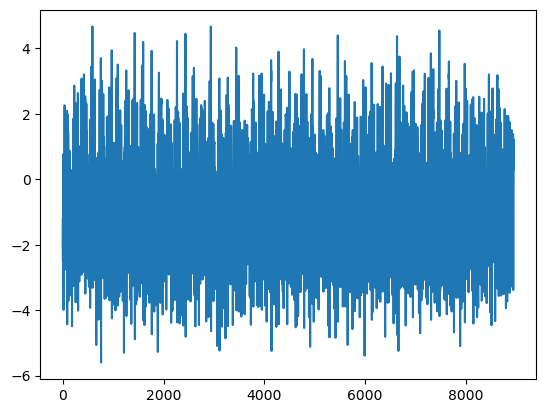

In [12]:
z_scores = np.array(z_scores_list)

z_scores = z_scores[24*5:]

plt.plot(z_scores)
plt.show()

$$ $$

## Slice and format the shift dataframe then save

In [13]:
# slice out anything that starts in 2024
sliced_shifts = shift_dataframe[shift_dataframe['start_time'] < pd.Timestamp('2024-01-01')]

# slice out anything that ends before 2023
sliced_shifts = sliced_shifts[sliced_shifts['end_time'] >= pd.Timestamp('2023-01-01')]

# clamp start times to begging of 2023 and recalculate duration based on end_time
cutoff = pd.Timestamp('2023-01-01 00:00:00')
mask = sliced_shifts['start_time'] < cutoff

# Update duration for affected rows (in hours)
sliced_shifts.loc[mask, 'duration'] = (
    sliced_shifts.loc[mask, 'end_time'] - cutoff
).dt.total_seconds() / 3600

# Clamp start_time to cutoff
sliced_shifts.loc[mask, 'start_time'] = cutoff


# set location ID column to int16
sliced_shifts['start_locationID'] = sliced_shifts['start_locationID'].astype(np.int16)

In [14]:
sliced_shifts

,start_time,start_locationID,duration,end_time
72,2023-01-01 00:00:00,141,0.726111,2023-01-01 00:43:34
100,2023-01-01 00:00:00,138,0.866667,2023-01-01 00:52:00
128,2023-01-01 00:00:00,238,0.733333,2023-01-01 00:44:00
130,2023-01-01 00:00:00,226,0.016667,2023-01-01 00:01:00
137,2023-01-01 00:00:00,65,0.750000,2023-01-01 00:45:00
...,...,...,...,...
2,2023-12-31 23:00:00,132,11.753889,2024-01-01 10:45:14
3,2023-12-31 23:00:00,138,5.170278,2024-01-01 04:10:13
4,2023-12-31 23:00:00,138,1.916667,2024-01-01 00:55:00
5,2023-12-31 23:00:00,164,7.266667,2024-01-01 06:16:00


In [15]:
# remove end_time (not required for simulation)
export_shifts = sliced_shifts.drop(columns=['end_time'])

In [16]:
export_shifts.to_parquet('shift_information.parquet')

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

# Automate generating shift information for 2023 simulations (scaled from 2013)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import time

from pathlib import Path
import os

In [2]:
def remove_outliers_iqr(arr, k=3.0):
    """
    Remove extreme outliers from a 1D numpy array using the IQR rule.
    Returns a new array with only non-outlier values.
    """
    arr = np.asarray(arr)
    if arr.size == 0:
        return arr  # keep empty arrays as-is

    # Use percentiles for robustness
    q1, q3 = np.percentile(arr, [25, 75])
    iqr = q3 - q1
    if iqr == 0:
        # All values nearly identical; nothing to remove
        return arr

    lower = q1 - k * iqr
    upper = q3 + k * iqr

    mask = (arr >= lower) & (arr <= upper)

    removed = arr[~mask]
    if len(removed) > 0:
        #print("Removed:", removed)
        #print("Kepted:", arr[mask])
        #print("\n\n")
        pass
    return arr[mask]


def generate_shifts_dataframe(driver_levels_2013 = 33_300, driver_levels_2023 = 11_700, extra_reducer=0.7):

    # load data
    print("Shift start counts...")
    shift_counts_df = pd.read_pickle("data/sim_info/shift_start_counts_arrays.pkl")
    
    print("Shift durations...")
    shift_durations_df = pd.read_pickle("data/sim_info/shift_arrays.pkl")
    
    print("Shift start locations...")
    shift_start_locationsIDs_df = pd.read_pickle("data/sim_info/shift_start_location_arrays.pkl")
    
    print("driver counts...")
    driver_count_df = pd.read_pickle("data/sim_info/driver_count_arrays.pkl")


    # filter extreme outliers in count dataframes
    shift_counts_df = shift_counts_df.map(remove_outliers_iqr)
    driver_count_df = driver_count_df.map(remove_outliers_iqr)



    # scale the count levels from 2013 to 2023 with extra reducer for shift hours and stuff
    reduction = extra_reducer * (driver_levels_2023 / driver_levels_2013)
    

    # apply scaling
    print("Applying 2013 to 2023 scaling")
    
    shift_counts_df = shift_counts_df.map(lambda arr: np.rint(arr * reduction).astype(np.int16))
    driver_count_df = driver_count_df.map(lambda arr: np.rint(arr * reduction).astype(np.int16))

    
    # calculate mean and std for z-score adjustments
    driver_count_means = driver_count_df.map(np.mean)
    driver_count_stds = driver_count_df.map(np.std)

    



    
    # GENERATION SECTION



    # start a couple days before 2023
    start_time = pd.Timestamp('2022-12-20')
    adjustment_start = start_time + pd.Timedelta(days=5)
    
    # z_scores to add to remove shifts at
    low_z_threshold = -3
    high_z_threshold = 3
    
    
    # end a couple days after 2023
    timestamp_end = pd.Timestamp('2024-01-02')
    #timestamp_end = pd.Timestamp('2023-01-02')
    
    shifts_dataframe = pd.DataFrame(columns=['start_time', 'start_locationID', 'duration', 'end_time'])
    
    
    z_scores_list = []
    z_adjustment_messages = []
    
    hours = pd.date_range(start=start_time, end=timestamp_end, freq="h")
    n = len(hours)
    
    
    # make this long enough for max duration you might see (pick a safe buffer)
    end_counts = np.zeros(n + 72*2, dtype=np.int32)  # e.g. +144 hours buffer
    current_active = 0
    
    chunks = []
    meta = []
    
    for t_idx, curr_time in tqdm(enumerate(hours), total=len(hours)):
    
        current_active -= end_counts[t_idx]
    
        # get hour and day of week for current time
        hour = curr_time.hour
        dow  = curr_time.day_of_week
    
        # sample the number of shifts to generate
        num_starts = np.random.choice(shift_counts_df[dow][hour])
    
        # sample data arrays for these shifts
        new_location_IDs = np.random.choice(shift_start_locationsIDs_df[dow][hour], replace=True, size=num_starts)
        new_durations    = np.random.choice(shift_durations_df[dow][hour], replace=True, size=num_starts)
    
        # create new shifts
        new_shifts = []
        new_end_buckets = []
        for i in range(num_starts):
            # sample a new shift
            # I'm just going to start shifts on the hour
            new_shift_location_ID = new_location_IDs[i]
            new_shift_duration = new_durations[i]
            new_shift_end = curr_time + pd.Timedelta(hours=new_shift_duration)
    
            end_bucket = t_idx + np.ceil(new_shift_duration).astype(np.int32)
            end_counts[end_bucket] += 1
            new_end_buckets.append(end_bucket)
    
            new_shifts.append({
                'start_time' : curr_time,
                'start_locationID' : new_shift_location_ID,
                'duration' : new_shift_duration,
                'end_time' : new_shift_end
            })
    
        # create new shift dataframe
        new_shift_df = pd.DataFrame(new_shifts)
    
        
        current_active += num_starts
    
        chunks.append(new_shift_df)
        meta.append(np.array(new_end_buckets))    

        # since extreme outliers have been filtered with IQR, I'm going to
        # use standard z-score for outlier detection for generation driver counts
        obs_mean = driver_count_means[dow][hour]
        obs_std  = driver_count_stds[dow][hour]
        z_score = (current_active - obs_mean) / obs_std
    
        if z_score > high_z_threshold and curr_time > adjustment_start: # there's too many drivers
    
            # remove drivers to bring back into range
            desired_amount = obs_mean + high_z_threshold * obs_std
    
            amount_to_remove = int(current_active - desired_amount)
    
            log_message = f"{curr_time.strftime('%Y-%m-%d')}   dow: {dow},  hour: {hour},   current: {current_active}, amount to remove: {amount_to_remove}"
            #print(log_message)
            z_adjustment_messages.append(log_message)

            # remove rows from previous chunks and current_active count
            k = amount_to_remove
            while k > 0 and chunks:
                last_df = chunks[-1]
                last_buckets = meta[-1]
                take = min(k, len(last_df))
    
                # undo those shifts in the end_counts + active count
                np.add.at(end_counts, last_buckets[-take:], -1)
                current_active -= take
    
                # trim/pop chunk
                if take == len(last_df):
                    chunks.pop(); meta.pop()
                else:
                    chunks[-1] = last_df.iloc[:-take]
                    meta[-1] = last_buckets[:-take]
                k -= take
    
            
    
    
        if z_score < low_z_threshold and curr_time > adjustment_start: # theres too little drivers
    
            # remove drivers to bring back into range
            desired_amount = obs_mean + low_z_threshold * obs_std
    
            amount_to_add = int(desired_amount - current_active)
    
            log_message = f"{curr_time.strftime('%Y-%m-%d')}   dow: {dow},  hour: {hour},   current: {current_active}, amount to add: {amount_to_add}"
            #print(log_message)
            z_adjustment_messages.append(log_message)
    
            
            # create that many drivers
            new_location_IDs = np.random.choice(shift_start_locationsIDs_df[dow][hour], replace=True, size=amount_to_add)
            new_durations    = np.random.choice(shift_durations_df[dow][hour], replace=True, size=amount_to_add)
    
            # create new shifts
            new_shifts = []
            new_end_buckets = []
            for i in range(amount_to_add):
                # sample a new shift
                # I'm just going to start shifts on the hour
                new_shift_location_ID = new_location_IDs[i]
                new_shift_duration = new_durations[i]
                new_shift_end = curr_time + pd.Timedelta(hours=new_shift_duration)
        
                end_bucket = t_idx + np.ceil(new_shift_duration).astype(np.int32)
                end_counts[end_bucket] += 1
                new_end_buckets.append(end_bucket)
        
                new_shifts.append({
                    'start_time' : curr_time,
                    'start_locationID' : new_shift_location_ID,
                    'duration' : new_shift_duration,
                    'end_time' : new_shift_end
                })
        
            # create new shift dataframe
            new_shift_df = pd.DataFrame(new_shifts)
        
            
            current_active += amount_to_add
        
            chunks[-1] = pd.concat([chunks[-1], new_shift_df], ignore_index=True)
            meta[-1] = np.concat((meta[-1], np.array(new_end_buckets)))
    
    
        z_scores_list.append(z_score)


    print("Creating dataframe:...")
    z_scores = np.array(z_scores_list)
    shift_dataframe = pd.concat(chunks)
    print("done")


    # return dataframe and z_scores. Filtering is done in other loop
    return shift_dataframe, z_scores
    


def create_test_shift_information(test_folder, make_folder):

    # Directory *where this script is located*
    #script_dir = Path(__file__).resolve().parent
    # Treat the argument as relative to the script dir
    test_folder = Path(test_folder)

    #print(test_folder)


    if make_folder:
        # check that the test folder does not exist
        if test_folder.is_dir():
            raise FileNotFoundError(f"Test folder {test_folder} exists while make_folder is True!")

        os.mkdir(test_folder)

    else:
        # check that test folder exists
        if not test_folder.is_dir():
            raise FileNotFoundError(f"Test folder {test_folder} doesn't exist!")

    # make export files
    shift_dataframe_export_path  = test_folder / "shift_information.parquet"
    z_scores_plot_export         = test_folder / "zscores_plot.jpg"
    z_scores_numpy_export        = test_folder / "below_thresholds.npy"

    
    
    # generate z_scores and shift dataframe
    shift_dataframe, z_scores = generate_shifts_dataframe()



    # format and clean shift dataframe to save
    

    # slice out anything that starts in 2024
    sliced_shifts = shift_dataframe[shift_dataframe['start_time'] < pd.Timestamp('2024-01-01')]
    
    # slice out anything that ends before 2023
    sliced_shifts = sliced_shifts[sliced_shifts['end_time'] >= pd.Timestamp('2023-01-01')]
    
    # clamp start times to begging of 2023 and recalculate duration based on end_time
    cutoff = pd.Timestamp('2023-01-01 00:00:00')
    mask = sliced_shifts['start_time'] < cutoff
    
    # Update duration for affected rows (in hours)
    sliced_shifts.loc[mask, 'duration'] = (
        sliced_shifts.loc[mask, 'end_time'] - cutoff
    ).dt.total_seconds() / 3600
    
    # Clamp start_time to cutoff
    sliced_shifts.loc[mask, 'start_time'] = cutoff


    # set location ID column to int16
    sliced_shifts['start_locationID'] = sliced_shifts['start_locationID'].astype(np.int16)
    # remove end_time (not required for simulation)
    export_shifts = sliced_shifts.drop(columns=['end_time'])

    export_shifts.to_parquet(shift_dataframe_export_path)




    # slice out beginning z_scores, make plot and save
    z_scores = z_scores[24*5:]

    low_z_threshold = -3
    high_z_threshold = 3
    out_of_threshold = ((z_scores < low_z_threshold) | (z_scores > high_z_threshold)).mean() * 100

    
    
    plt.plot(z_scores)
    plt.title(f"driver_count z_score plot, {out_of_threshold}% out of threshold")
    plt.xlabel("hour index")
    plt.ylabel("active_driver_count_z_score")

    plt.savefig(z_scores_plot_export, dpi=300, bbox_inches='tight')
    plt.close()


    np.save(z_scores_numpy_export, z_scores)

    


In [3]:

from IPython.display import clear_output


# for loop to create test folders with shift information

base_folder = "test_v5/"

test_folders = [f"test_{i}" for i in range(8)]


for test_folder in test_folders:


    print("Test_folder:", test_folder)

    test_folder = base_folder + "/" + test_folder

    
    create_test_shift_information(test_folder, make_folder=True)


    clear_output(wait=False)

    


$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$


$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$


# Generate shift information for ground truth 2013 simulation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import time

from pathlib import Path
import os

In [2]:
def remove_outliers_iqr(arr, k=3.0):
    """
    Remove extreme outliers from a 1D numpy array using the IQR rule.
    Returns a new array with only non-outlier values.
    """
    arr = np.asarray(arr)
    if arr.size == 0:
        return arr  # keep empty arrays as-is

    # Use percentiles for robustness
    q1, q3 = np.percentile(arr, [25, 75])
    iqr = q3 - q1
    if iqr == 0:
        # All values nearly identical; nothing to remove
        return arr

    lower = q1 - k * iqr
    upper = q3 + k * iqr

    mask = (arr >= lower) & (arr <= upper)

    removed = arr[~mask]
    if len(removed) > 0:
        #print("Removed:", removed)
        #print("Kepted:", arr[mask])
        #print("\n\n")
        pass
    return arr[mask]


def generate_ground_truth_shifts_dataframe():

    # load data
    print("Shift start counts...")
    shift_counts_df = pd.read_pickle("data/sim_info/shift_start_counts_arrays.pkl")
    
    print("Shift durations...")
    shift_durations_df = pd.read_pickle("data/sim_info/shift_arrays.pkl")
    
    print("Shift start locations...")
    shift_start_locationsIDs_df = pd.read_pickle("data/sim_info/shift_start_location_arrays.pkl")
    
    print("driver counts...")
    driver_count_df = pd.read_pickle("data/sim_info/driver_count_arrays.pkl")


    # filter extreme outliers in count dataframes
    shift_counts_df = shift_counts_df.map(remove_outliers_iqr)
    driver_count_df = driver_count_df.map(remove_outliers_iqr)


    # calculate mean and std for z-score adjustments
    driver_count_means = driver_count_df.map(np.mean)
    driver_count_stds = driver_count_df.map(np.std)



    
    # GENERATION SECTION



    # start a couple days before 2013
    start_time = pd.Timestamp('2012-12-20')
    adjustment_start = start_time + pd.Timedelta(days=5)
    
    # z_scores to add to remove shifts at
    low_z_threshold = -3
    high_z_threshold = 3
    
    
    # end a couple days after 2013
    timestamp_end = pd.Timestamp('2014-01-02')
    #timestamp_end = pd.Timestamp('2013-01-02')
    
    shifts_dataframe = pd.DataFrame(columns=['start_time', 'start_locationID', 'duration', 'end_time'])
    
    
    z_scores_list = []
    z_adjustment_messages = []
    
    hours = pd.date_range(start=start_time, end=timestamp_end, freq="h")
    n = len(hours)
    
    
    # make this long enough for max duration you might see (pick a safe buffer)
    end_counts = np.zeros(n + 72*2, dtype=np.int32)  # e.g. +144 hours buffer
    current_active = 0
    
    chunks = []
    meta = []
    
    for t_idx, curr_time in tqdm(enumerate(hours), total=len(hours)):
    
        current_active -= end_counts[t_idx]
    
        # get hour and day of week for current time
        hour = curr_time.hour
        dow  = curr_time.day_of_week
    
        # sample the number of shifts to generate
        num_starts = np.random.choice(shift_counts_df[dow][hour])
    
        # sample data arrays for these shifts
        new_location_IDs = np.random.choice(shift_start_locationsIDs_df[dow][hour], replace=True, size=num_starts)
        new_durations    = np.random.choice(shift_durations_df[dow][hour], replace=True, size=num_starts)
    
        # create new shifts
        new_shifts = []
        new_end_buckets = []
        for i in range(num_starts):
            # sample a new shift
            # I'm just going to start shifts on the hour
            new_shift_location_ID = new_location_IDs[i]
            new_shift_duration = new_durations[i]
            new_shift_end = curr_time + pd.Timedelta(hours=new_shift_duration)
    
            end_bucket = t_idx + np.ceil(new_shift_duration).astype(np.int32)
            end_counts[end_bucket] += 1
            new_end_buckets.append(end_bucket)
    
            new_shifts.append({
                'start_time' : curr_time,
                'start_locationID' : new_shift_location_ID,
                'duration' : new_shift_duration,
                'end_time' : new_shift_end
            })
    
        # create new shift dataframe
        new_shift_df = pd.DataFrame(new_shifts)
    
        
        current_active += num_starts
    
        chunks.append(new_shift_df)
        meta.append(np.array(new_end_buckets))    

        # since extreme outliers have been filtered with IQR, I'm going to
        # use standard z-score for outlier detection for generation driver counts
        obs_mean = driver_count_means[dow][hour]
        obs_std  = driver_count_stds[dow][hour]
        z_score = (current_active - obs_mean) / obs_std
    
        if z_score > high_z_threshold and curr_time > adjustment_start: # there's too many drivers
    
            # remove drivers to bring back into range
            desired_amount = obs_mean + high_z_threshold * obs_std
    
            amount_to_remove = int(current_active - desired_amount)
    
            log_message = f"{curr_time.strftime('%Y-%m-%d')}   dow: {dow},  hour: {hour},   current: {current_active}, amount to remove: {amount_to_remove}"
            #print(log_message)
            z_adjustment_messages.append(log_message)

            # remove rows from previous chunks and current_active count
            k = amount_to_remove
            while k > 0 and chunks:
                last_df = chunks[-1]
                last_buckets = meta[-1]
                take = min(k, len(last_df))
    
                # undo those shifts in the end_counts + active count
                np.add.at(end_counts, last_buckets[-take:], -1)
                current_active -= take
    
                # trim/pop chunk
                if take == len(last_df):
                    chunks.pop(); meta.pop()
                else:
                    chunks[-1] = last_df.iloc[:-take]
                    meta[-1] = last_buckets[:-take]
                k -= take
    
            
    
    
        if z_score < low_z_threshold and curr_time > adjustment_start: # theres too little drivers
    
            # remove drivers to bring back into range
            desired_amount = obs_mean + low_z_threshold * obs_std
    
            amount_to_add = int(desired_amount - current_active)
    
            log_message = f"{curr_time.strftime('%Y-%m-%d')}   dow: {dow},  hour: {hour},   current: {current_active}, amount to add: {amount_to_add}"
            #print(log_message)
            z_adjustment_messages.append(log_message)
    
            
            # create that many drivers
            new_location_IDs = np.random.choice(shift_start_locationsIDs_df[dow][hour], replace=True, size=amount_to_add)
            new_durations    = np.random.choice(shift_durations_df[dow][hour], replace=True, size=amount_to_add)
    
            # create new shifts
            new_shifts = []
            new_end_buckets = []
            for i in range(amount_to_add):
                # sample a new shift
                # I'm just going to start shifts on the hour
                new_shift_location_ID = new_location_IDs[i]
                new_shift_duration = new_durations[i]
                new_shift_end = curr_time + pd.Timedelta(hours=new_shift_duration)
        
                end_bucket = t_idx + np.ceil(new_shift_duration).astype(np.int32)
                end_counts[end_bucket] += 1
                new_end_buckets.append(end_bucket)
        
                new_shifts.append({
                    'start_time' : curr_time,
                    'start_locationID' : new_shift_location_ID,
                    'duration' : new_shift_duration,
                    'end_time' : new_shift_end
                })
        
            # create new shift dataframe
            new_shift_df = pd.DataFrame(new_shifts)
        
            
            current_active += amount_to_add
        
            chunks[-1] = pd.concat([chunks[-1], new_shift_df], ignore_index=True)
            meta[-1] = np.concat((meta[-1], np.array(new_end_buckets)))
    
    
        z_scores_list.append(z_score)


    print("Creating dataframe:...")
    z_scores = np.array(z_scores_list)
    shift_dataframe = pd.concat(chunks)
    print("done")


    # return dataframe and z_scores. Filtering is done in other loop
    return shift_dataframe, z_scores
    


def create_ground_truth_test_shift_information(test_folder, make_folder):

    # Directory *where this script is located*
    #script_dir = Path(__file__).resolve().parent
    # Treat the argument as relative to the script dir
    test_folder = Path(test_folder)

    #print(test_folder)


    if make_folder:
        # check that the test folder does not exist
        if test_folder.is_dir():
            raise FileNotFoundError(f"Test folder {test_folder} exists while make_folder is True!")

        os.mkdir(test_folder)

    else:
        # check that test folder exists
        if not test_folder.is_dir():
            raise FileNotFoundError(f"Test folder {test_folder} doesn't exist!")

    # make export files
    shift_dataframe_export_path  = test_folder / "shift_information.parquet"
    z_scores_plot_export         = test_folder / "zscores_plot.jpg"
    z_scores_numpy_export        = test_folder / "below_thresholds.parquet"

    
    
    # generate z_scores and shift dataframe
    shift_dataframe, z_scores = generate_ground_truth_shifts_dataframe()



    # format and clean shift dataframe to save
    

    # slice out anything that starts in 2014
    sliced_shifts = shift_dataframe[shift_dataframe['start_time'] < pd.Timestamp('2014-01-01')]
    
    # slice out anything that ends before 2013
    sliced_shifts = sliced_shifts[sliced_shifts['end_time'] >= pd.Timestamp('2013-01-01')]
    
    # clamp start times to begging of 2013 and recalculate duration based on end_time
    cutoff = pd.Timestamp('2013-01-01 00:00:00')
    mask = sliced_shifts['start_time'] < cutoff
    
    # Update duration for affected rows (in hours)
    sliced_shifts.loc[mask, 'duration'] = (
        sliced_shifts.loc[mask, 'end_time'] - cutoff
    ).dt.total_seconds() / 3600
    
    # Clamp start_time to cutoff
    sliced_shifts.loc[mask, 'start_time'] = cutoff


    # set location ID column to int16
    sliced_shifts['start_locationID'] = sliced_shifts['start_locationID'].astype(np.int16)
    # remove end_time (not required for simulation)
    export_shifts = sliced_shifts.drop(columns=['end_time'])

    export_shifts.to_parquet(shift_dataframe_export_path)




    # slice out beginning z_scores, make plot and save
    z_scores = z_scores[24*5:]

    low_z_threshold = -3
    high_z_threshold = 3
    out_of_threshold = ((z_scores < low_z_threshold) | (z_scores > high_z_threshold)).mean() * 100

    
    
    plt.plot(z_scores)
    plt.title(f"driver_count z_score plot, {out_of_threshold}% out of threshold")
    plt.xlabel("hour index")
    plt.ylabel("active_driver_count_z_score")

    plt.savefig(z_scores_plot_export, dpi=300, bbox_inches='tight')
    plt.close()


    np.save(z_scores_numpy_export, z_scores)

In [3]:
from IPython.display import clear_output


# for loop to create test folders with shift information

base_folder = "gt_sims_v1"

test_folders = [f"test_{i}" for i in range(8)]

test_folders = ["test_0"]

for test_folder in test_folders:


    print("Test_folder:", test_folder)

    test_folder = base_folder + "/" + test_folder

    
    create_ground_truth_test_shift_information(test_folder, make_folder=True)


    clear_output(wait=False)

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

# Update simulation to be numpy and numba based

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import time
import yaml

import os
import sys
from pathlib import Path

In [2]:
import gt_simulation_v4

In [3]:
from gt_simulation_v4 import check_series_is_full, convert_array_df, fill_df_missing_cols_rows, get_PU_to_DO_connections, load_sampling_stuff
from gt_simulation_v4 import TaxiFleet

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
test_folder_arg = 'gt_sims_v1/test_3'

In [6]:
# Directory *where this script is located*
#script_dir = Path(__file__).resolve().parent
# Treat the argument as relative to the script dir
#test_folder = (script_dir / test_folder_arg).resolve()
test_folder = Path(test_folder_arg)

if not test_folder.is_dir():
    raise FileNotFoundError(f"Test folder {test_folder} doesn't exist!")

# check paths special to test (should just be trip and config)
shift_df_path = test_folder / "shift_information.parquet"
test_config_path = test_folder / "test_config.yaml"

if not shift_df_path.exists():
    raise FileNotFoundError(f"Shift file {shift_df_path} doesn't exist within test folder!")
if not test_config_path.exists():
    raise FileNotFoundError(f"Config file {test_config_path} doesn't exist within test folder!")


# Create paths for exports
sim_time_export              = test_folder / "gen_info.txt"
rejects_export_path          = test_folder / "rejects.parquet"
below_thresholds_export_path = test_folder / "below_thresholds.parquet"
unfilled_trips_export_path   = test_folder / "unfilled_trips.parquet"


# read test config file
with open(test_config_path,'r') as f:
    config_dict = yaml.safe_load(f)




# load sampling distributions
sampling_stuff = load_sampling_stuff()

# load information for DO to PU connections (filtered by occurance minimum threshold, default is 365)
PU_to_DO_info = get_PU_to_DO_connections(threshold=config_dict['connections_threshold'])


# load in raw trips
unformatted_trips = pd.read_parquet("data/sim_info/ground_truth_trips_raw.parquet")
unformatted_trips = unformatted_trips.sort_values(by="PU_time")


# Convert trip times into seconds since start of 2013
t0 = pd.Timestamp("2013-01-01 00:00:00")

trips = unformatted_trips.copy()


# if there's a set simulation cutoff, then slice trips dataframe
if config_dict['end_date']:
    end_date = pd.Timestamp(config_dict['end_date'])
    print("Simulation cutoff:", end_date)

    trips = trips[trips['PU_time'] <= end_date]


# Seconds since start of 2013
trips['PU'] = (trips['PU_time'] - t0).dt.total_seconds().astype('int')
trips['DO'] = (trips['DO_time'] - t0).dt.total_seconds().astype('int')
trips.drop(columns=['PU_time', 'DO_time'], inplace=True)

# create duration column in seconds and then drop dropoff time
trips['duration'] = trips['DO'] - trips['PU']
trips.drop(columns=['DO'], inplace=True)
trips = trips.sort_values(by='PU')

# reset trips index (used for flag to clean taxi cab array)
trips = trips.reset_index()
trips.drop(columns=['index'], inplace=True)


# load in test trip df
shift_df = pd.read_parquet(shift_df_path)

# convert start time to seconds from start of 2013
shift_df['start_time'] = (shift_df['start_time']  - t0).dt.total_seconds().astype('int')
# convert duration to seconds (is currently hours)
shift_df['duration'] = (shift_df['duration'] * 3600).round().astype('int64')


Loading sampling info:
Shift durations...
Shift start locations...
driver counts...
driver count deltas...
In between miles...
Filling in missing columns and rows with empty arrays
missing cols: {104, 57, 105}
missing rows: {104, 57, 105}
In between durations...
Filling in missing columns and rows with empty arrays
missing cols: {104, 57, 105}
missing rows: {104, 57, 105}
Converting measurements
Simulation cutoff: 2013-01-10 00:00:00


In [9]:
# create fleet with loaded data and config settings
fleet = TaxiFleet(
    taxi_shifts_df=shift_df, 
    taxi_range= config_dict['taxi_range'], 
    trips_df=trips, 
    sampling_stuff=sampling_stuff, 
    PU_to_DO_info=PU_to_DO_info,
    low_range_threshold=config_dict['low_range_threshold']
)

cleaning_time = 0

# run through all trips
start = time.time()

cab_array_cleaning_interval = config_dict['cab_array_cleaning_interval']

backlog_waiting_seconds = config_dict['backlog_waiting_minutes'] * 60

takens = []
b_trip_takens = []

backlogged_trips = []

back_filled_trips = []
unfilled_trips = []

for row in tqdm(trips.itertuples(index=True), total=len(trips)):

    # back log eval loop
    while len(backlogged_trips) > 0:

        if backlogged_trips[0].PU < row.PU + backlog_waiting_seconds:  # the backlogged trip has waited at least the waiting period
            b_trip = backlogged_trips.pop(0)

            # run b_trip through backlog try function
            b_trip_taken = fleet.assign_trip(pickup_time_seconds = b_trip.PU + backlog_waiting_seconds, 
                                             pickup_location     = b_trip.PU_LocationID, 
                                             duration            = b_trip.duration, 
                                             distance            = b_trip.distance, 
                                             dropoff_location    = b_trip.DO_LocationID
                                            )

            if b_trip_taken:
                # add to back_filled_trips
                back_filled_trips.append(b_trip)
                
            else:
                # add to unfilled trips
                unfilled_trips.append(b_trip)

            b_trip_takens.append(b_trip_taken)

        else:
            # latest backlog hasn't waited long enough.
            # So break out to continue normal trips to backlog has waited enough
            break
    
    
    taken = fleet.assign_trip(
        pickup_time_seconds = row.PU, 
        pickup_location     = row.PU_LocationID, 
        duration            = row.duration, 
        distance            = row.distance, 
        dropoff_location    = row.DO_LocationID
    )

    takens.append(taken)

    if row.Index % 5_000 == 0 and row.Index > 100:
        #before_size = np.array([len(taxi_array) for taxi_array in fleet.cab_array]).sum()
        #print("before_size:", fleet.next_location_taxi_index)
        clean_start = time.time()
        fleet.clean_cab_array(curr_time_seconds=row.PU - backlog_waiting_seconds)
        cleaning_time += time.time() - clean_start
        #after_size = np.array([len(taxi_array) for taxi_array in fleet.cab_array]).sum()
        #print("after_size:", after_size)
        #print("before_size:", fleet.next_location_taxi_index)
        #print(np.sum(fleet.next_location_taxi_index))
        #break

    if not taken:
        backlogged_trips.append(row)

end = time.time()

100%|█████████████████████████████████████████████████████████████████| 3785874/3785874 [00:49<00:00, 76217.90it/s]


In [10]:
print("total_trip_processing_time:", fleet.total_trip_processing_time)
print("search_primary_time:", fleet.search_primary_time)
print("search_secondary_time:", fleet.search_secondary_time)
print("time_spawning", fleet.time_spawning)
print("post_find_time", fleet.post_find_time)
print()
print("primary searches:", fleet.search_primary_count)
print("secondary searches:", fleet.search_secondary_count)
print("failed searches:", fleet.search_fails)
print()
print("cleaning time:", cleaning_time)

total_trip_processing_time: 38.82381200790405
search_primary_time: 8.320680379867554
search_secondary_time: 12.55385136604309
time_spawning 1.8021795749664307
post_find_time 11.894316911697388

primary searches: 2132108
secondary searches: 1543252
failed searches: 345132

cleaning time: 0.2736949920654297
